In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif



# Load data
summary_features = pd.read_csv('/content/summary_transcript_speech.csv')
df = pd.read_csv('/content/Ground_Truth_Table.csv')

labels = ['PTSD_Label', 'Depression_Label', 'Appetite_Label', 'Agency_Label', 'Anxiety_Label', 'Sleep_Label']

# Preprocess features (1st)
X = summary_features.copy()
for col in X.select_dtypes("object"):
    X[col], _ = X[col].factorize()
X = X.loc[:, (X != 0).any(axis=0)]  # Drop all-zero columns
discrete_features = X.dtypes == int

# MI function
def make_mi_scores(X, y, discrete_features):
    mi = mutual_info_classif(X, y, discrete_features=discrete_features)
    return pd.Series(mi, index=X.columns).sort_values(ascending=False)

***With*** **Hyperparameter Tuninig**



=== Processing: PTSD_Label ===

>>> Hyperparameter tuning: Logistic Regression (Thresh 0.35)
Best Params: {'model__solver': 'saga', 'model__penalty': 'l2', 'model__max_iter': 1000, 'model__C': np.float64(0.013894954943731374)}
CV-best F1 : 0.492

>>> Hyperparameter tuning: Ridge Classifier (Thresh 0.0)
Best Params: {'model__alpha': np.float64(0.001)}
CV-best F1 : 0.449


=== Processing: Depression_Label ===

>>> Hyperparameter tuning: Logistic Regression (Thresh 0.35)
Best Params: {'model__solver': 'saga', 'model__penalty': 'l2', 'model__max_iter': 1000, 'model__C': np.float64(0.006105402296585327)}
CV-best F1 : 0.423

>>> Hyperparameter tuning: Ridge Classifier (Thresh 0.0)
Best Params: {'model__alpha': np.float64(0.003593813663804626)}
CV-best F1 : 0.329


=== Processing: Appetite_Label ===

>>> Hyperparameter tuning: Logistic Regression (Thresh 0.35)
Best Params: {'model__solver': 'saga', 'model__penalty': 'l2', 'model__max_iter': 1000, 'model__C': np.float64(0.002682695795279727)

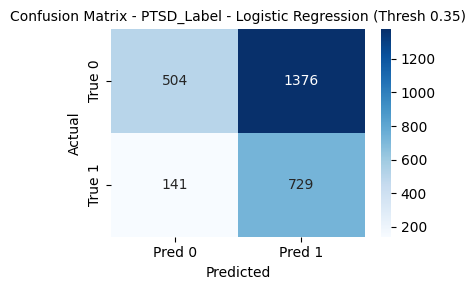


--- Ridge Classifier (Thresh 0.0) ---
Train Accuracy : 0.798 ± 0.023
Test Accuracy  : 0.625 ± 0.060
Sensitivity    : 0.537 ± 0.121
Specificity    : 0.666 ± 0.067


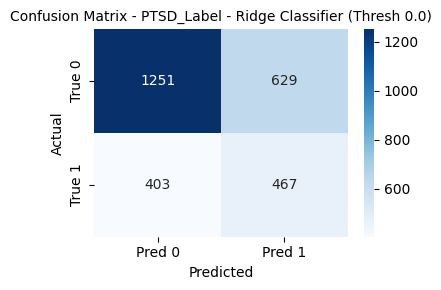



=== Results for: Depression_Label ===

--- Logistic Regression (Thresh 0.35) ---
Train Accuracy : 0.495 ± 0.027
Test Accuracy  : 0.443 ± 0.055
Sensitivity    : 0.893 ± 0.085
Specificity    : 0.301 ± 0.077


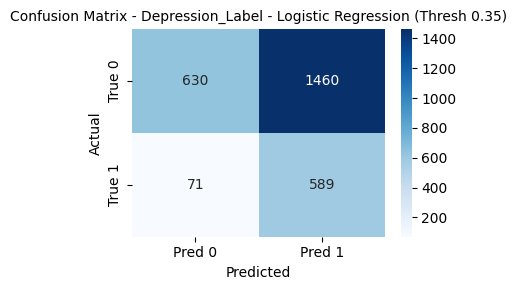


--- Ridge Classifier (Thresh 0.0) ---
Train Accuracy : 0.832 ± 0.018
Test Accuracy  : 0.654 ± 0.061
Sensitivity    : 0.512 ± 0.135
Specificity    : 0.699 ± 0.074


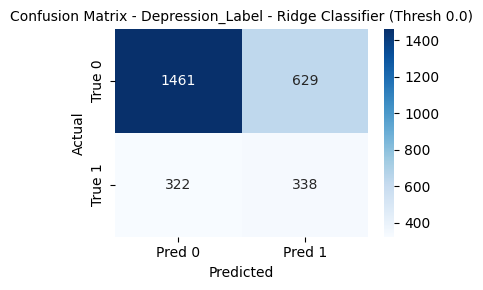



=== Results for: Appetite_Label ===

--- Logistic Regression (Thresh 0.35) ---
Train Accuracy : 0.392 ± 0.027
Test Accuracy  : 0.370 ± 0.048
Sensitivity    : 0.952 ± 0.060
Specificity    : 0.144 ± 0.070


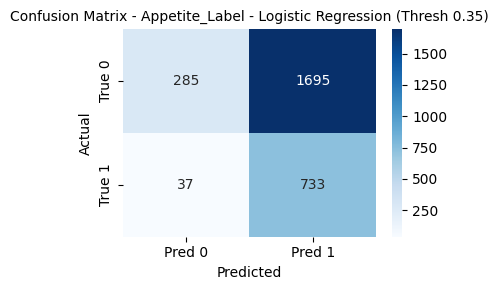


--- Ridge Classifier (Thresh 0.0) ---
Train Accuracy : 0.799 ± 0.018
Test Accuracy  : 0.587 ± 0.048
Sensitivity    : 0.474 ± 0.105
Specificity    : 0.630 ± 0.072


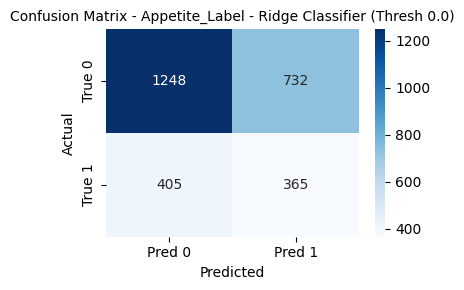



=== Results for: Agency_Label ===

--- Logistic Regression (Thresh 0.35) ---
Train Accuracy : 0.677 ± 0.018
Test Accuracy  : 0.577 ± 0.043
Sensitivity    : 0.866 ± 0.069
Specificity    : 0.286 ± 0.080


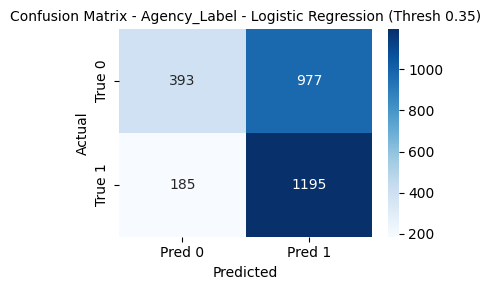


--- Ridge Classifier (Thresh 0.0) ---
Train Accuracy : 0.759 ± 0.020
Test Accuracy  : 0.612 ± 0.060
Sensitivity    : 0.614 ± 0.090
Specificity    : 0.611 ± 0.090


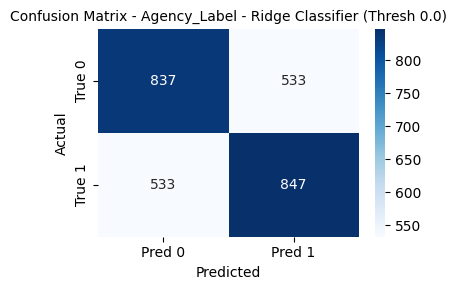



=== Results for: Anxiety_Label ===

--- Logistic Regression (Thresh 0.35) ---
Train Accuracy : 0.639 ± 0.016
Test Accuracy  : 0.585 ± 0.034
Sensitivity    : 0.945 ± 0.050
Specificity    : 0.166 ± 0.054


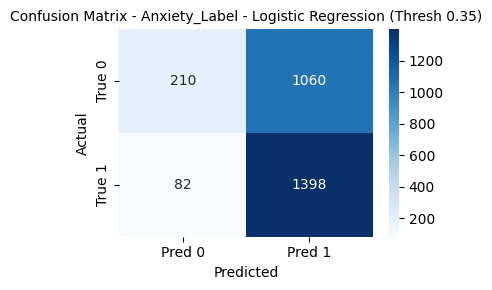


--- Ridge Classifier (Thresh 0.0) ---
Train Accuracy : 0.732 ± 0.017
Test Accuracy  : 0.570 ± 0.059
Sensitivity    : 0.597 ± 0.088
Specificity    : 0.540 ± 0.093


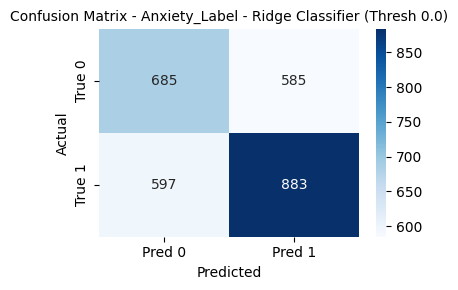



=== Results for: Sleep_Label ===

--- Logistic Regression (Thresh 0.35) ---
Train Accuracy : 0.577 ± 0.024
Test Accuracy  : 0.517 ± 0.050
Sensitivity    : 0.906 ± 0.063
Specificity    : 0.298 ± 0.073


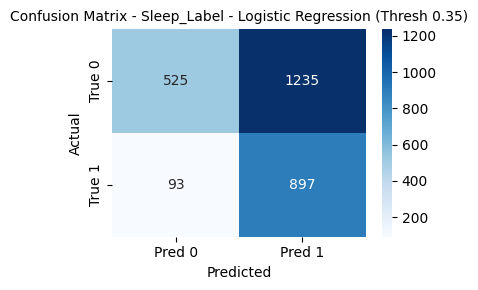


--- Ridge Classifier (Thresh 0.0) ---
Train Accuracy : 0.812 ± 0.020
Test Accuracy  : 0.619 ± 0.066
Sensitivity    : 0.572 ± 0.116
Specificity    : 0.646 ± 0.079


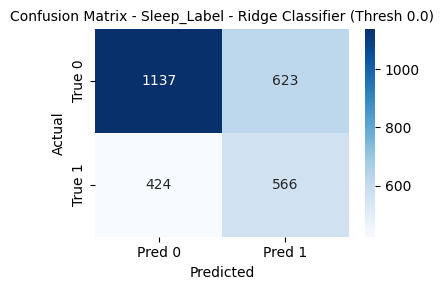

In [ ]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
from sklearn.base import clone
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings

warnings.filterwarnings("ignore")

# Settings
scaler = StandardScaler()
smote = SMOTE()
N_ITER = 30  # hyperparameter samples
CV_FOLDS = 5
N_REPEATS = 10
RANDOM = 42

all_results = {}

# ===== MAIN LOOP OVER LABELS =====
for target_label in labels:
    print(f"\n\n=== Processing: {target_label} ===")
    y = df[target_label]

    # Feature Selection
    mi_scores = make_mi_scores(X, y, discrete_features)
    mi_scores_nonzero = mi_scores[mi_scores > 0]
    # Extract numerical values before calculating percentile
    percentile_80 = np.percentile(mi_scores_nonzero.values, 80)
    top_20_by_percentile = mi_scores_nonzero[mi_scores_nonzero >= percentile_80].index
    X_top = X[top_20_by_percentile]

    # Splitter
    rskf = RepeatedStratifiedKFold(n_splits=CV_FOLDS, n_repeats=N_REPEATS, random_state=RANDOM)

    models = {
        'Logistic Regression (Thresh 0.35)': LogisticRegression(max_iter=1000, class_weight='balanced'),
        'Ridge Classifier (Thresh 0.0)': RidgeClassifier()
    }

    param_dists = {
        'Logistic Regression (Thresh 0.35)': {
            'penalty': ['l2'],
            'C': np.logspace(-4, 1, 15),          # far tougher regularisation
            'solver': ['saga'],                   # supports all three penalties
            'max_iter': [1000]                    # stable convergence
        },
        'Ridge Classifier (Thresh 0.0)': {
            'alpha': np.logspace(-3, 2, 10)
        }
    }


    model_metrics = {}

    for model_name, base_model in models.items():
        print(f"\n>>> Hyperparameter tuning: {model_name}")
        pipe = Pipeline([
            ('scale', scaler),
            ('model', base_model)
        ])

        search = RandomizedSearchCV(
            estimator=pipe,
            param_distributions={f'model__{k}': v for k, v in param_dists[model_name].items()},
            scoring='f1',
            n_iter=N_ITER,
            cv=rskf,
            random_state=RANDOM,
            n_jobs=-1,
            verbose=0
        )
        search.fit(X_top, y)
        print(f"Best Params: {search.best_params_}")
        print(f"CV-best F1 : {search.best_score_:.3f}")

        # ===================== Post-Tuning 5x10 Fold Eval =====================
        train_accs, test_accs = [], []
        sensitivities, specificities = [], []
        y_true_all, y_pred_all = [], []

        for train_idx, test_idx in rskf.split(X_top, y):
            X_train, X_test = X_top.iloc[train_idx], X_top.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            X_res, y_res = smote.fit_resample(X_train, y_train)

            model = clone(search.best_estimator_.named_steps['model'])
            model.fit(X_res, y_res)

            # Train prediction
            if 'Ridge' in model_name:
                y_train_pred = (model.decision_function(X_train) > 0.0).astype(int)
                y_test_pred = (model.decision_function(X_test) > 0.0).astype(int)
            else:
                y_train_pred = (model.predict_proba(X_train)[:, 1] > 0.35).astype(int)
                y_test_pred = (model.predict_proba(X_test)[:, 1] > 0.35).astype(int)

            train_accs.append(accuracy_score(y_train, y_train_pred))
            test_accs.append(accuracy_score(y_test, y_test_pred))

            report = classification_report(y_test, y_test_pred, output_dict=True, zero_division=0)
            sensitivities.append(report.get('1', {}).get('recall', 0.0))
            specificities.append(report.get('0', {}).get('recall', 0.0))

            y_true_all.extend(y_test)
            y_pred_all.extend(y_test_pred)

        # Save
        model_metrics[model_name] = {
            'train_acc': train_accs,
            'test_acc': test_accs,
            'sensitivity': sensitivities,
            'specificity': specificities,
            'y_true': y_true_all,
            'y_pred': y_pred_all
        }

    all_results[target_label] = model_metrics

# =================== REPORTING SECTION ===================
for label, results in all_results.items():
    print(f"\n\n=== Results for: {label} ===")
    for model, data in results.items():
        print(f"\n--- {model} ---")
        print(f"Train Accuracy : {np.mean(data['train_acc']):.3f} ± {np.std(data['train_acc']):.3f}")
        print(f"Test Accuracy  : {np.mean(data['test_acc']):.3f} ± {np.std(data['test_acc']):.3f}")
        print(f"Sensitivity    : {np.mean(data['sensitivity']):.3f} ± {np.std(data['sensitivity']):.3f}")
        print(f"Specificity    : {np.mean(data['specificity']):.3f} ± {np.std(data['specificity']):.3f}")

        # Confusion Matrix
        cm = confusion_matrix(data['y_true'], data['y_pred'])
        plt.figure(figsize=(4, 3))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Pred 0', 'Pred 1'],
                    yticklabels=['True 0', 'True 1'])
        plt.title(f'Confusion Matrix - {label} - {model}', fontsize=10)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.show()

Without Hyperparameter Tuninig



=== Processing: PTSD_Label ===


=== Processing: Depression_Label ===


=== Processing: Appetite_Label ===


=== Processing: Agency_Label ===


=== Processing: Anxiety_Label ===


=== Processing: Sleep_Label ===


=== Results for: PTSD_Label ===

--- Logistic Regression (Threshold 0.35) ---
Train Accuracy = 0.7602 ± 0.0224
Test Accuracy  = 0.5775 ± 0.0635
Sensitivity    = 0.6134
Specificity    = 0.5609
Precision      = 0.3934
F1 Score       = 0.4776
⚠️ Overfitting Warning: Train-Test Gap = 0.18

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.56      0.64      1880
           1       0.39      0.61      0.48       870

    accuracy                           0.58      2750
   macro avg       0.58      0.59      0.56      2750
weighted avg       0.64      0.58      0.59      2750



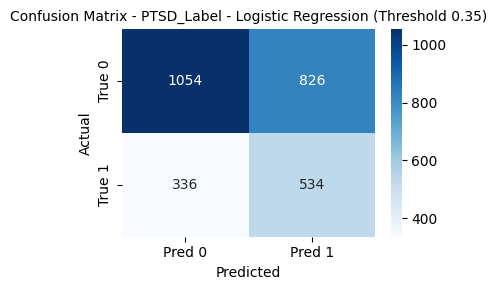


--- Ridge Classifier (SMOTE, Threshold 0.0) ---
Train Accuracy = 0.7951 ± 0.0201
Test Accuracy  = 0.6022 ± 0.0669
Sensitivity    = 0.5020
Specificity    = 0.6486
Precision      = 0.3977
F1 Score       = 0.4406
⚠️ Overfitting Warning: Train-Test Gap = 0.19

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.65      0.69      1880
           1       0.40      0.50      0.44       870

    accuracy                           0.60      2750
   macro avg       0.57      0.58      0.57      2750
weighted avg       0.63      0.60      0.61      2750



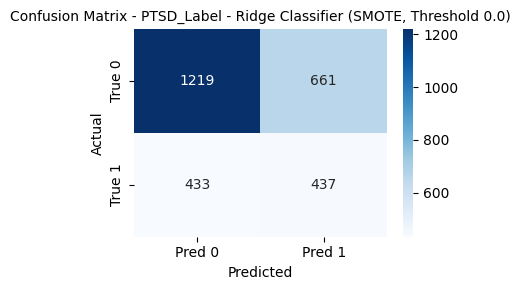



=== Results for: Depression_Label ===

--- Logistic Regression (Threshold 0.35) ---
Train Accuracy = 0.7997 ± 0.0235
Test Accuracy  = 0.6036 ± 0.0526
Sensitivity    = 0.5307
Specificity    = 0.6268
Precision      = 0.3117
F1 Score       = 0.3901
⚠️ Overfitting Warning: Train-Test Gap = 0.20

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.63      0.71      2090
           1       0.31      0.53      0.39       660

    accuracy                           0.60      2750
   macro avg       0.56      0.58      0.55      2750
weighted avg       0.69      0.60      0.63      2750



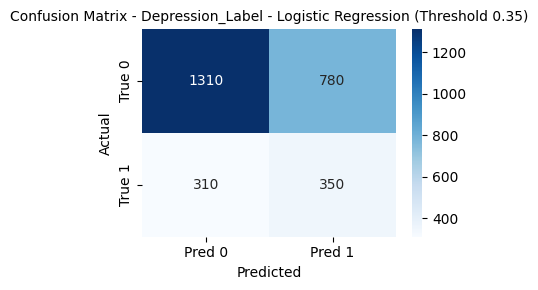


--- Ridge Classifier (SMOTE, Threshold 0.0) ---
Train Accuracy = 0.8298 ± 0.0189
Test Accuracy  = 0.6327 ± 0.0492
Sensitivity    = 0.4719
Specificity    = 0.6832
Precision      = 0.3191
F1 Score       = 0.3781
⚠️ Overfitting Warning: Train-Test Gap = 0.20

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.68      0.74      2090
           1       0.32      0.47      0.38       660

    accuracy                           0.63      2750
   macro avg       0.56      0.58      0.56      2750
weighted avg       0.69      0.63      0.65      2750



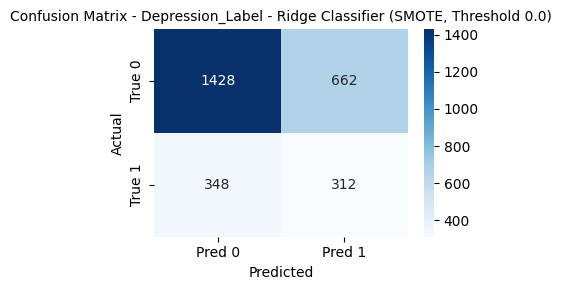



=== Results for: Appetite_Label ===

--- Logistic Regression (Threshold 0.35) ---
Train Accuracy = 0.7503 ± 0.0270
Test Accuracy  = 0.5385 ± 0.0677
Sensitivity    = 0.5454
Specificity    = 0.5355
Precision      = 0.3151
F1 Score       = 0.3971
⚠️ Overfitting Warning: Train-Test Gap = 0.21

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.54      0.63      1980
           1       0.31      0.55      0.40       770

    accuracy                           0.54      2750
   macro avg       0.53      0.54      0.51      2750
weighted avg       0.63      0.54      0.56      2750



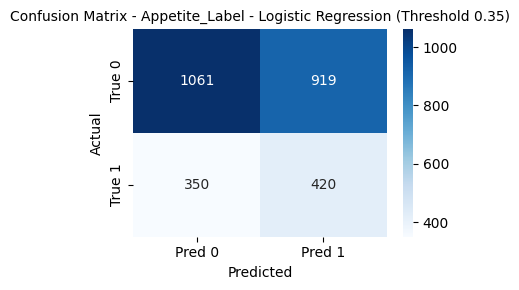


--- Ridge Classifier (SMOTE, Threshold 0.0) ---
Train Accuracy = 0.7962 ± 0.0209
Test Accuracy  = 0.5793 ± 0.0636
Sensitivity    = 0.4347
Specificity    = 0.6350
Precision      = 0.3166
F1 Score       = 0.3639
⚠️ Overfitting Warning: Train-Test Gap = 0.22

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.64      0.68      1980
           1       0.32      0.44      0.37       770

    accuracy                           0.58      2750
   macro avg       0.53      0.54      0.53      2750
weighted avg       0.62      0.58      0.60      2750



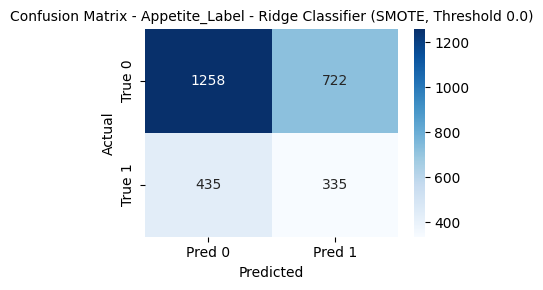



=== Results for: Agency_Label ===

--- Logistic Regression (Threshold 0.35) ---
Train Accuracy = 0.7905 ± 0.0185
Test Accuracy  = 0.6091 ± 0.0499
Sensitivity    = 0.7310
Specificity    = 0.4861
Precision      = 0.5901
F1 Score       = 0.6510
⚠️ Overfitting Warning: Train-Test Gap = 0.18

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.49      0.55      1370
           1       0.59      0.73      0.65      1380

    accuracy                           0.61      2750
   macro avg       0.62      0.61      0.60      2750
weighted avg       0.62      0.61      0.60      2750



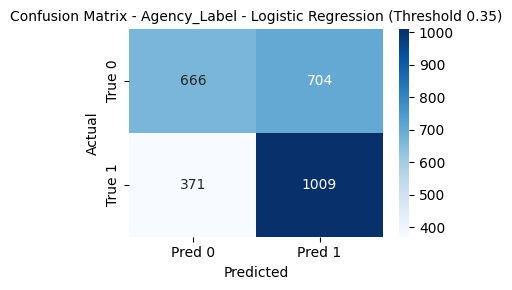


--- Ridge Classifier (SMOTE, Threshold 0.0) ---
Train Accuracy = 0.8069 ± 0.0191
Test Accuracy  = 0.5993 ± 0.0542
Sensitivity    = 0.6057
Specificity    = 0.5926
Precision      = 0.5996
F1 Score       = 0.5996
⚠️ Overfitting Warning: Train-Test Gap = 0.21

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.59      0.60      1370
           1       0.60      0.61      0.60      1380

    accuracy                           0.60      2750
   macro avg       0.60      0.60      0.60      2750
weighted avg       0.60      0.60      0.60      2750



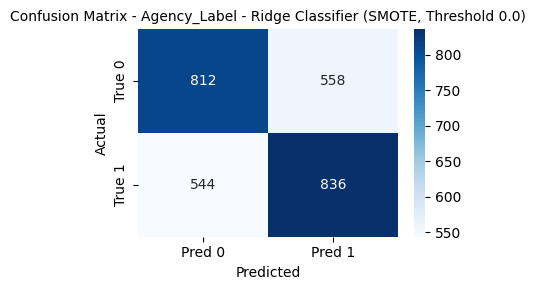



=== Results for: Anxiety_Label ===

--- Logistic Regression (Threshold 0.35) ---
Train Accuracy = 0.7668 ± 0.0212
Test Accuracy  = 0.5658 ± 0.0545
Sensitivity    = 0.6974
Specificity    = 0.4125
Precision      = 0.5812
F1 Score       = 0.6325
⚠️ Overfitting Warning: Train-Test Gap = 0.20

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.41      0.47      1270
           1       0.58      0.70      0.63      1480

    accuracy                           0.57      2750
   macro avg       0.56      0.55      0.55      2750
weighted avg       0.56      0.57      0.56      2750



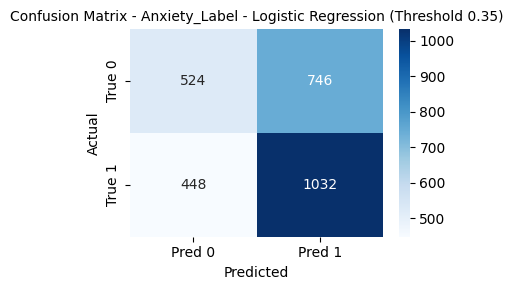


--- Ridge Classifier (SMOTE, Threshold 0.0) ---
Train Accuracy = 0.7783 ± 0.0212
Test Accuracy  = 0.5505 ± 0.0660
Sensitivity    = 0.5479
Specificity    = 0.5534
Precision      = 0.5912
F1 Score       = 0.5659
⚠️ Overfitting Warning: Train-Test Gap = 0.23

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.55      0.53      1270
           1       0.59      0.55      0.57      1480

    accuracy                           0.55      2750
   macro avg       0.55      0.55      0.55      2750
weighted avg       0.55      0.55      0.55      2750



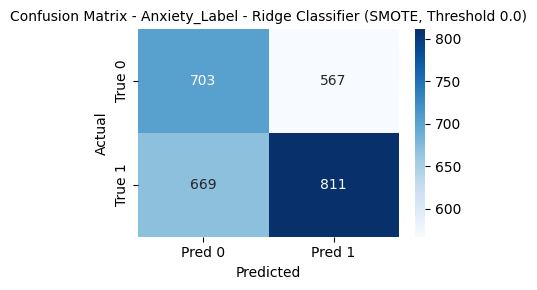



=== Results for: Sleep_Label ===

--- Logistic Regression (Threshold 0.35) ---
Train Accuracy = 0.7578 ± 0.0275
Test Accuracy  = 0.5811 ± 0.0631
Sensitivity    = 0.6748
Specificity    = 0.5285
Precision      = 0.4469
F1 Score       = 0.5356
⚠️ Overfitting Warning: Train-Test Gap = 0.18

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.53      0.62      1760
           1       0.45      0.67      0.54       990

    accuracy                           0.58      2750
   macro avg       0.59      0.60      0.58      2750
weighted avg       0.64      0.58      0.59      2750



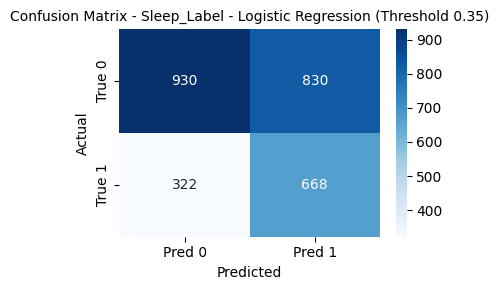


--- Ridge Classifier (SMOTE, Threshold 0.0) ---
Train Accuracy = 0.8033 ± 0.0209
Test Accuracy  = 0.6051 ± 0.0624
Sensitivity    = 0.5457
Specificity    = 0.6386
Precision      = 0.4603
F1 Score       = 0.4963
⚠️ Overfitting Warning: Train-Test Gap = 0.20

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.64      0.67      1760
           1       0.46      0.55      0.50       990

    accuracy                           0.61      2750
   macro avg       0.59      0.59      0.59      2750
weighted avg       0.62      0.61      0.61      2750



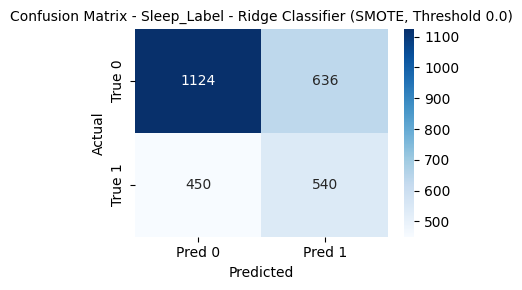

In [ ]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import mutual_info_classif
import warnings

warnings.filterwarnings('ignore')


# Classification settings
scaler = StandardScaler()
smote = SMOTE()
n_splits = 5
n_runs = 10
threshold = 0.35

# Results storage
all_results = {}

# ======= MAIN LOOP OVER LABELS =======
for target_label in labels:
    print(f"\n\n=== Processing: {target_label} ===")
    y = df[target_label]

    # Recompute MI and select top 20% (2nd and 3rd step of feature selection)
    # Compute MI scores
    mi_scores = make_mi_scores(X, y, discrete_features)

    # Filter out zero MI scores
    mi_scores_nonzero = mi_scores[mi_scores > 0]

    # Compute 80th percentile from non-zero MI scores
    percentile_80 = np.percentile(mi_scores_nonzero, 80)

    # Select features with MI ≥ 80th percentile of non-zero scores
    top_20_by_percentile = mi_scores_nonzero[mi_scores_nonzero >= percentile_80].index

    # Filter X
    X_top_mi = X[top_20_by_percentile]

    # Init metrics
    metrics_dict = {
        'Logistic Regression (Threshold 0.35)': {},
        'Ridge Classifier (SMOTE, Threshold 0.0)': {}
    }
    for model_name in metrics_dict:
        metrics_dict[model_name] = {
            'train_acc': [], 'test_acc': [],
            'sensitivity': [], 'specificity': [],
            'precision': [], 'f1': [],
            'y_true': [], 'y_pred': []
        }

    # Loop through CV runs
    for run in range(n_runs):
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=run)
        for train_idx, test_idx in skf.split(X_top_mi, y):
            X_train, X_test = X_top_mi.iloc[train_idx], X_top_mi.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
            class_weights = {0: 1.0, 1: y_train.value_counts()[0] / y_train.value_counts()[1]}

            models = {
                'Logistic Regression (Threshold 0.35)': LogisticRegression(max_iter=1000, class_weight=class_weights),
                'Ridge Classifier (SMOTE, Threshold 0.0)': RidgeClassifier()
            }

            for name, model in models.items():
                if 'Ridge' in name:
                    model.fit(X_resampled, y_resampled)
                    y_train_pred = (model.decision_function(X_train) > 0.0).astype(int)
                    y_test_pred = (model.decision_function(X_test) > 0.0).astype(int)
                else:
                    model.fit(X_train, y_train)
                    y_train_pred = (model.predict_proba(X_train)[:, 1] > threshold).astype(int)
                    y_test_pred = (model.predict_proba(X_test)[:, 1] > threshold).astype(int)

                metrics_dict[name]['train_acc'].append(accuracy_score(y_train, y_train_pred))
                metrics_dict[name]['test_acc'].append(accuracy_score(y_test, y_test_pred))
                report = classification_report(y_test, y_test_pred, output_dict=True, zero_division=0)
                metrics_dict[name]['sensitivity'].append(report.get('1', {}).get('recall', 0.0))
                metrics_dict[name]['specificity'].append(report.get('0', {}).get('recall', 0.0))
                metrics_dict[name]['precision'].append(report.get('1', {}).get('precision', 0.0))
                metrics_dict[name]['f1'].append(report.get('1', {}).get('f1-score', 0.0))
                metrics_dict[name]['y_true'].extend(y_test)
                metrics_dict[name]['y_pred'].extend(y_test_pred)

    # Save results
    all_results[target_label] = metrics_dict

# ======= SUMMARY & PLOTS =======
for label, results in all_results.items():
    print(f"\n\n=== Results for: {label} ===")
    for model, data in results.items():
        print(f"\n--- {model} ---")
        print(f"Train Accuracy = {np.mean(data['train_acc']):.4f} ± {np.std(data['train_acc']):.4f}")
        print(f"Test Accuracy  = {np.mean(data['test_acc']):.4f} ± {np.std(data['test_acc']):.4f}")
        print(f"Sensitivity    = {np.mean(data['sensitivity']):.4f}")
        print(f"Specificity    = {np.mean(data['specificity']):.4f}")
        print(f"Precision      = {np.mean(data['precision']):.4f}")
        print(f"F1 Score       = {np.mean(data['f1']):.4f}")
        gap = np.mean(data['train_acc']) - np.mean(data['test_acc'])
        if gap > 0.1:
            print(f"⚠️ Overfitting Warning: Train-Test Gap = {gap:.2f}")

        print("\nClassification Report:")
        print(classification_report(data['y_true'], data['y_pred'], zero_division=0))

        cm = confusion_matrix(data['y_true'], data['y_pred'])
        plt.figure(figsize=(4, 3))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
        plt.title(f'Confusion Matrix - {label} - {model}', fontsize=10)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.show()


In [ ]:
import pandas as pd

# Create a dictionary to hold the average and std deviation for each metric and model
results_data = {}

for model_name in all_run_model_accuracies.keys():
    avg_accuracy = np.mean(all_run_model_accuracies[model_name])
    std_accuracy = np.std(all_run_model_accuracies[model_name])
    avg_sensitivity = np.mean(all_run_model_sensitivity[model_name])
    std_sensitivity = np.std(all_run_model_sensitivity[model_name])
    avg_specificity = np.mean(all_run_model_specificity[model_name])
    std_specificity = np.std(all_run_model_specificity[model_name])

    results_data[model_name] = {
        'Average Accuracy': f"{avg_accuracy:.4f} +/- {std_accuracy:.4f}",
        'Average Sensitivity': f"{avg_sensitivity:.4f} +/- {std_sensitivity:.4f}",
        'Average Specificity': f"{avg_specificity:.4f} +/- {std_specificity:.4f}"
    }

# Create a pandas DataFrame from the results data
results_df = pd.DataFrame.from_dict(results_data, orient='index')

# Display the DataFrame as a table
print("\n--- Average Metrics Across All Runs and Folds ---")
display(results_df)


--- Average Metrics Across All Runs and Folds ---


,Average Accuracy,Average Sensitivity,Average Specificity
Logistic Regression (Weighted),0.6375 +/- 0.0609,0.4474 +/- 0.1297,0.6976 +/- 0.0693
MLP Classifier (Weighted),0.4015 +/- 0.0733,0.8725 +/- 0.1061,0.2525 +/- 0.1100
"XGBoost Classifier (Weighted, Threshold 0.35)",0.6945 +/- 0.0501,0.3997 +/- 0.1565,0.7876 +/- 0.0600
SVM Classifier (Weighted),0.6793 +/- 0.0381,0.3518 +/- 0.1201,0.7828 +/- 0.0454
Ridge Classifier (smote),0.6240 +/- 0.0476,0.4891 +/- 0.1315,0.6665 +/- 0.0540
